# AI4Code: EDA

Questions:

- How many cells on average per notebook?
- What is the breakdown of markdown vs code cells.
- How many notebooks share the same ancestor_id
- What languages are in the markdown cells (If there are several languages, then select the one that prevails in the markdown cells)
    - the same as in the previous steps but with a breakdown by language
- what characters are in the markdown cells (looking for what is garbage and can be purged from the data)

## Used notebooks:
- https://www.kaggle.com/code/robikscube/google-ai4code-data-to-parquet-twitch-stream-eda
- https://www.kaggle.com/code/odins0n/ai4code-detailed-eda
- https://www.kaggle.com/code/ilyaryabov/fasttext-public-model-teaching/notebook

In [1]:
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
RAW_DATA_PATH = '../../data/raw'
PROCESSING_DATA_PATH = '../../data/merged/'

In [3]:
%%time
train = pd.read_parquet(os.path.join(PROCESSING_DATA_PATH, 'train_all.parquet'))
train = train.astype({'cell_type': 'category', 'source': 'str'}, errors='raise') 

train.head()

CPU times: user 7.49 s, sys: 4.54 s, total: 12 s
Wall time: 20 s


,id,cell,cell_type,source,order,ancestor_id,parent_id
0,00015c83e2717b,2e94bd7a,markdown,## Note : This Kernel is a Fork from the amazi...,0,aa2da37e,317b65d12af9df
1,00015c83e2717b,3e99dee9,markdown,## About The Competition : Detecting Steel Def...,1,aa2da37e,317b65d12af9df
2,00015c83e2717b,b5e286ea,markdown,Reference :http://faculty.neu.edu.cn/yunhyan/...,2,aa2da37e,317b65d12af9df
3,00015c83e2717b,da4f7550,markdown,## import modules and define models,3,aa2da37e,317b65d12af9df
4,00015c83e2717b,c417225b,code,import numpy as np # linear algebra\nimport pa...,4,aa2da37e,317b65d12af9df


## Surface analysis

### Averate cell by type per notebook

code        4204552
markdown    2166036
Name: cell_type, dtype: int64


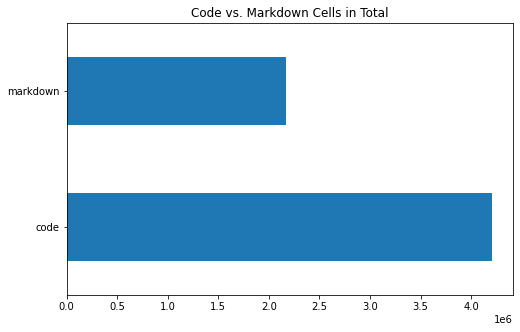

In [4]:
train["cell_type"].value_counts().plot(
    kind="barh",
    title="Code vs. Markdown Cells in Total",
    #color=my_pal[2],
    figsize=(8, 5)
)
print(train["cell_type"].value_counts())
plt.show()


The median number of cells per notebook is: 35.0


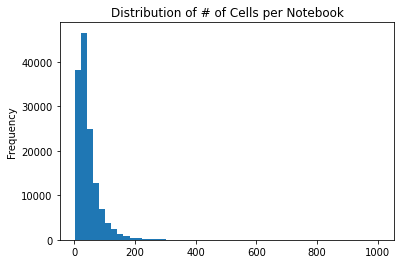

In [5]:
# Number of Cells per id
train["id"].value_counts().plot(
    kind="hist", bins=50, title="Distribution of # of Cells per Notebook"
)
print("The median number of cells per notebook is:", train["id"].value_counts().median())
plt.show()


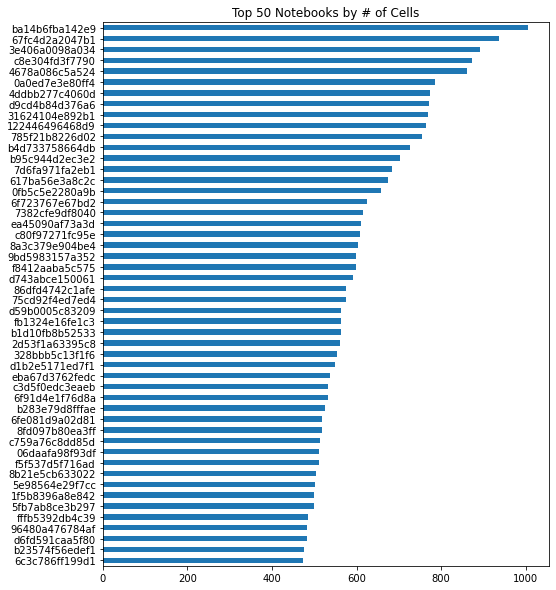

In [6]:
train["id"].value_counts().head(50).sort_values().plot(
    kind="barh", figsize=(8, 10), title="Top 50 Notebooks by # of Cells"
)
plt.show()


### What's the most forked notebook

<AxesSubplot:title={'center':'Top Forked Notebooks'}>

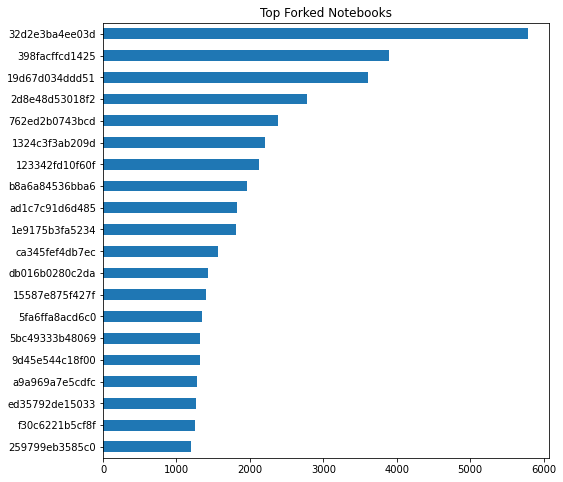

In [7]:
# Find top Id
# Find the most "parent"
train["parent_id"].value_counts().head(20).sort_values().plot(
    kind="barh", figsize=(8, 8), title="Top Forked Notebooks"
)


## Deeper analysis

### Code cells Length distribution

In [8]:
code_df = train[train.cell_type == "code"].source
code_lengths = np.array([len(df.split()) for df in code_df])
print(f'\033[94m Min Code Cells Length = ', min(code_lengths))
print(f'\033[94m Mean Code cells Length = ', round(np.mean(code_lengths),2))
print(f'\033[94m Max Code Cells Length = ', max(code_lengths))
print(f'\033[94m Median Code cells Length = ', round(np.median(code_lengths),2))
print(f'\033[94m Std Code cells Length = ', round(np.std(code_lengths),2))

 Min Code Cells Length =  1
 Mean Code cells Length =  25.24
 Max Code Cells Length =  74589
 Median Code cells Length =  10.0
 Std Code cells Length =  100.65


Text(0.5, 0, 'Lenght of Code Cells')

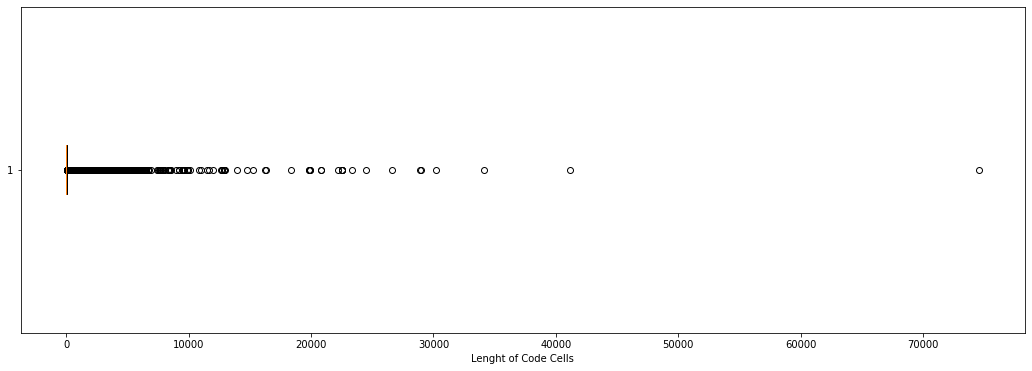

In [9]:
fig,ax= plt.subplots(figsize= (18,6))
plt.boxplot(code_lengths, vert = False)
plt.xlabel("Lenght of Code Cells")

### Markdown Cells Length Distribution

In [10]:
mkd_df = train[train.cell_type == "markdown"].source
mkd_lengths = np.array([len(df.split()) for df in mkd_df])
print(f'\033[94m Min Markdown Cells Length = ', min(mkd_lengths))
print(f'\033[94m Mean Markdown cells Length = ', round(np.mean(mkd_lengths),2))
print(f'\033[94m Max Markdown Cells Length = ', max(mkd_lengths))
print(f'\033[94m Median Code cells Length = ', round(np.median(mkd_lengths),2))
print(f'\033[94m Std Code cells Length = ', round(np.std(mkd_lengths),2))

 Min Markdown Cells Length =  1
 Mean Markdown cells Length =  29.42
 Max Markdown Cells Length =  38939
 Median Code cells Length =  11.0
 Std Code cells Length =  70.39


Text(0.5, 0, 'Lenght of Markdown Cells')

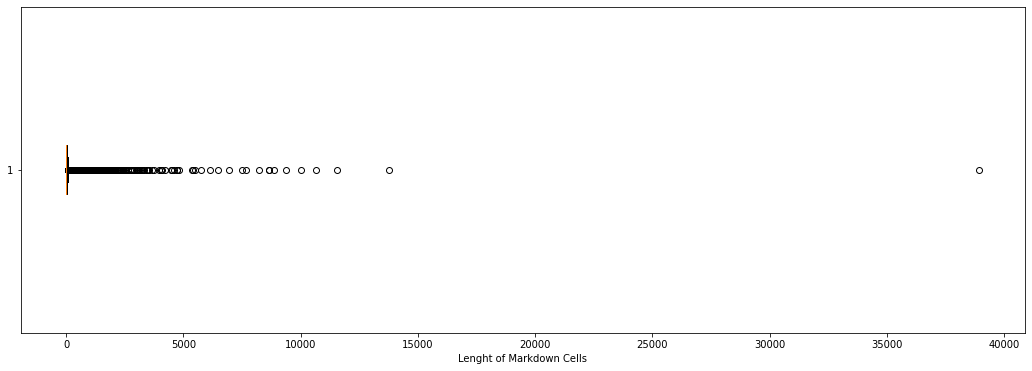

In [11]:
fig,ax= plt.subplots(figsize= (18,6))
plt.boxplot(mkd_lengths, vert = False)
plt.xlabel("Lenght of Markdown Cells")

### Notebooks cells count

In [12]:
# Calculate cells per notebook
counts_df = train[['id', 'cell', 'cell_type']].groupby(['id','cell_type']).count().reset_index()
counts_df = counts_df.groupby(['id', 'cell_type'])['cell'].aggregate('first').unstack()
counts_df.head()

cell_type,code,markdown
id,,
00015c83e2717b,72,21
0001bdd4021779,11,2
0001daf4c2c76d,178,51
0002115f48f982,8,1
00035108e64677,23,11


In [13]:
counts_df["total"] = counts_df["code"] + counts_df["markdown"]
counts_df.describe()

cell_type,code,markdown,total
count,139255.000000,139255.000000,139255.000000
mean,30.193185,15.554458,45.747643
std,26.957549,17.223786,40.085904
min,1.000000,1.000000,2.000000
25%,14.000000,5.000000,21.000000
50%,23.000000,11.000000,35.000000
75%,38.000000,20.000000,57.000000
max,809.000000,537.000000,1005.000000


In [14]:
counts_df.median()


cell_type
code        23.0
markdown    11.0
total       35.0
dtype: float64

In [15]:
either_one = counts_df[(counts_df["markdown"] == 1) | (counts_df["code"] == 1 )] 
both_one = counts_df[(counts_df["markdown"] == 1) & (counts_df["code"] == 1 )] 
code_count_one = counts_df[counts_df["code"] == 1 ]
markdown_count_one  = counts_df[counts_df["markdown"] == 1 ]

print(f"\033[94mTotal notebook with either 1 code cell or 1 markdown cell = ", len(either_one))
print(f"\033[94mTotal notebook with both 1 code cell and 1 markdown cell = ", len(both_one ))
print(f"\033[94mNotebook counts with only 1 code cell  = " ,len(code_count_one))
print(f"\033[94mNotebook counts with only 1 markdown cell  = " ,len(markdown_count_one))

Total notebook with either 1 code cell or 1 markdown cell =  11426
Total notebook with both 1 code cell and 1 markdown cell =  392
Notebook counts with only 1 code cell  =  737
Notebook counts with only 1 markdown cell  =  11081


### Cell Language Analysis

#### Process dataframe

In [25]:
import re

In [26]:
notebooks_lang_df = pd.read_csv(os.path.join(PROCESSING_DATA_PATH, 'notebooks_lang.csv'))
notebooks_lang_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139256 entries, 0 to 139255
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   notebook_id    139256 non-null  object
 1   notebook_lang  139256 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


In [27]:
notebooks_lang_df.iloc[1]

notebook_id                               00015c83e2717b
notebook_lang    (('__label__en',), array([0.93558216]))
Name: 1, dtype: object

In [28]:
def get_lang(row):
    row['notebook_lang'] = re.findall(r"__label__[a-z]{2}", row['notebook_lang'])[0].replace("__label__", "")
    return row

notebooks_lang = notebooks_lang_df.apply(get_lang, axis=1)
notebooks_lang

,notebook_id,notebook_lang
0,00001756c60be8,ru
1,00015c83e2717b,en
2,0001bdd4021779,en
3,0001daf4c2c76d,en
4,0002115f48f982,en
...,...,...
139251,fffc30d5a0bc46,en
139252,fffc3b44869198,en
139253,fffc63ff750064,en
139254,fffcd063cda949,en


In [34]:
notebooks_lang['notebook_lang'].value_counts().index

Index(['en', 'pt', 'ko', 'ja', 'ru', 'tr', 'es', 'zh', 'fr', 'id', 'vi', 'de',
       'it', 'th', 'pl', 'ca', 'uk', 'nl', 'fa', 'mn', 'hu', 'ar', 'da', 'cs',
       'ms', 'ro', 'el', 'hr', 'no', 'sr', 'fi', 'kn', 'la', 'sv', 'si', 'sk',
       'az', 'hi', 'sl', 'bn', 'ce', 'eo', 'uz', 'gl', 'he', 'sh', 'oc', 'eu',
       'ml', 'ht', 'tl', 'bg', 'nd', 'gd', 'my', 'lt', 'ie', 'mr', 'pa', 'te',
       'bs', 'ur', 'ne', 'qu', 'be', 'fy', 'jb', 'ta', 'sq', 'ky', 'af', 'mk',
       'ia'],
      dtype='object')

In [37]:
notebooks_lang.value_counts()

KeyError: 'en'

In [ ]:
notebooks_lang[notebooks_lang.notebook_lang == "ky"]

,notebook_id,notebook_lang
103250,bdb959d13c0218,ky


In [ ]:
train[train.id == "bdb959d13c0218"].source

4728280    # **Кыргыз тилинде коронавирустун тарашы боюнч...
4728281    import IPython\nurl = "https://flo.uri.sh/visu...
4728282    import numpy as np\nimport pandas as pd\nimpor...
4728283    cleaned_data = pd.read_csv('covid_19_data.csv'...
4728284    \nfig = px.line(grouped_china_date, x="Дата", ...
4728285    data['Облус'] = data['Облус'].fillna('')\ntemp...
4728286    cis = list(['Armenia','Azerbaijan','Belarus','...
4728287    fig = px.bar(latest_grouped.sort_values('Ооруг...
4728288    fig = px.bar(cis_grouped_latest.sort_values('О...
4728289    fig = px.line(grouped, x="Дата", y="Көз_жумган...
4728290    fig = px.bar(latest_grouped.sort_values('Көз_ж...
4728291    fig = px.bar(cis_grouped_latest.sort_values('К...
4728292    fig = px.bar(latest_grouped.sort_values('Айыкк...
4728293    fig = px.bar(cis_grouped_latest.sort_values('А...
4728294    temp = cleaned_data.groupby('Дата')['Айыкканда...
4728295    cleaned_latest = cleaned_data[cleaned_data['Да...
4728296    flg['Айыкканд

### Markdown cell analise

In [ ]:
counts_df.sort_values(['markdown'], ascending=False)

cell_type,code,markdown,total
id,,,
ba14b6fba142e9,468,537,1005
122446496468d9,305,459,764
4ddbb277c4060d,391,382,773
6f723767e67bd2,247,377,624
4678a086c5a524,492,368,860
...,...,...,...
31a8624adbabb8,16,1,17
7cad4668059663,11,1,12
e9dc4a0db40d9d,4,1,5


In [ ]:
TOP_N = 30

def save_markdowns(notebook_id):
    max_markdown_cells_df = train[train.id == notebook_id]
    max_markdown_cells_df = max_markdown_cells_df[train.cell_type == 'markdown']
    max_markdown_cells_df.source.to_csv(os.path.join(PROCESSING_DATA_PATH, 'markdowns', notebook_id + '.csv'), index=False)

for id in tqdm(counts_df.sort_values(['markdown'], ascending=False).index[:TOP_N]):
    save_markdowns(id)
#max_markdown_cells_df = train[train.id == counts_df.markdown.idxmax()]
#max_markdown_cells_df = max_markdown_cells_df[train.cell_type == 'markdown'].sort_values(['markdown'])
#max_markdown_cells_df

  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_15457/959808197.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  max_markdown_cells_df = max_markdown_cells_df[train.cell_type == 'markdown']
100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


In [ ]:
#max_markdown_cells_df.source.to_csv(os.path.join(PROCESSING_DATA_PATH, 'md_temp.csv'), index=False)

In [ ]:
cleaned_df = pd.read_parquet("../../data/clean/train_all_cleaned.parquet")
cleaned_df

: 

: 

In [ ]:
 cleaned_df[cleaned_df.cell_type == "markdown"].source.to_csv('../../data/clean/markdown_cell.csv')

OSError: Cannot save file into a non-existent directory: '../../clean'